# Assigment 2
## NAME : Hossam Fawzy Elsafty (23)
## Name : Yahia Elshahawy (87)

### Loading Data
- we will load the data using torchvision which contain a lot of popular  dataset
- we will have (50000 training set split to (40000 train and 10000 validation)
- and 10000 testing images

In [0]:

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import time
import os


In [0]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Files already downloaded and verified
Files already downloaded and verified
Train Size = 40000
Test Size = 10000
Validation Size = 10000


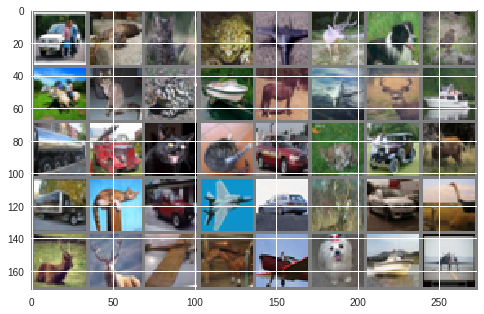

  car   cat   cat  frog


In [39]:

rgb_mean = (0.5, 0.5, 0.5)
rgb_std = (0.5, 0.5, 0.5)

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(rgb_mean, rgb_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(rgb_mean,rgb_std),
])


validation_split = .2
shuffle_dataset = True
random_seed= 42

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

# Creating data indices for training and validation splits:
dataset_size = len(trainset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=40, 
                                           sampler=train_sampler, num_workers=2)
validationloader = torch.utils.data.DataLoader(trainset, batch_size=40,
                                                sampler=valid_sampler, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=40,
                                         shuffle=False, num_workers=4)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



# printSizes
print("Train Size = {}".format(len(train_indices)))
print("Test Size = {}".format(len(testloader.dataset)))
print("Validation Size = {}".format(len(val_indices)))


# random images
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))



print(' '.join('%5s' % classes[labels[j]] for j in range(4)))



### Normal CNN Architecture
**Step 1: Build CNN ** 
    - Build architecture (3 conv2d layers each followed by a max pooling layer, then 3 fully connected layer)

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Cnn(nn.Module):
    size = 32
    def __init__(self, kernal):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernal, padding=1)
        self.size = (self.size + 3 - kernal) / 2

        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernal, padding=1)
        self.size = (self.size + 3 - kernal) / 2

        self.conv3 = nn.Conv2d(32, 64, kernal, padding=1)
        self.size = (self.size + 3 - kernal) / 2

        self.fc1 = nn.Linear(64 * int(self.size) * int(self.size), 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * int(self.size) * int(self.size))
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

**Step 2: Define train and validation functions ** 

In [0]:
# Training
def train(epoch,hist1):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    running_loss = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        #inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        running_loss = train_loss
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx % 100 == 99:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch, batch_idx + 1, running_loss/(batch_idx+1)))
            running_loss = 0.0
    hist1.append([train_loss/(batch_idx+1),100.*correct/total])
    print('Training Loss: {:.6f}, Training Accuracy: {:.3f}'.format(train_loss/(batch_idx+1),100.*correct/total))
def test(epoch,hist2,modelNum):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(validationloader):
            #inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            
    hist2.append([test_loss/(batch_idx+1),100.*correct/total])
    print('Validation Loss: {:.6f}, Validation Accuracy: {:.3f}'.format(test_loss/(batch_idx+1),100.*correct/total))
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt{}.t7'.format(modelNum))
        best_acc = acc

### Loss function and optimizer

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

**Step 3: Train 3 Different models each with different kernel size** 
- **the followings are the results**
    - Model 1: has kernel size of 1
        - Training Loss: 1.513572, Training Accuracy: 44.995
        - Validation Loss: 1.443929, Validation Accuracy: 47.790
        - Training time: 661.4017007350922 Seconds 
    - Model 2: has kernel size of 3
        - Training Loss: 1.244415, Training Accuracy: 55.278
        - Validation Loss: 1.204963, Validation Accuracy: 56.710
        - Training time: 675.8228912353516 Seconds
    - Model 3: has kernel size of 5
        - Training Loss: 1.166034, Training Accuracy: 57.907
        - Validation Loss: 1.092193, Validation Accuracy: 60.670
        - Training time: 594.4924886226654 Seconds

In [44]:
hist1 = [[],[],[]]
hist2 = [[],[],[]]
kernels = [1,3,5]

for i,kernel in enumerate(kernels):
  best_acc = 0
  net = Cnn(kernel) 
  optimizer = optim.SGD(net.parameters(), lr=0.01)
  start = time.time()
  print("for Model {}".format(i))
  for epoch in range(0, 11):
      train(epoch,hist1[i])
      test(epoch,hist2[i],i)
  end = time.time()
  print(end - start)
  torch.save(net.state_dict(), 'model{}.mdl'.format(i))

for Model 0

Epoch: 0
[0,   100] loss: 2.303
[0,   200] loss: 2.302
[0,   300] loss: 2.302
[0,   400] loss: 2.301
[0,   500] loss: 2.301
[0,   600] loss: 2.301
[0,   700] loss: 2.300
[0,   800] loss: 2.299
[0,   900] loss: 2.299
[0,  1000] loss: 2.298
Training Loss: 2.297900, Training Accuracy: 11.783
Validation Loss: 2.286015, Validation Accuracy: 16.290
Saving..

Epoch: 1
[1,   100] loss: 2.288
[1,   200] loss: 2.285
[1,   300] loss: 2.282
[1,   400] loss: 2.278
[1,   500] loss: 2.274
[1,   600] loss: 2.268
[1,   700] loss: 2.260
[1,   800] loss: 2.250
[1,   900] loss: 2.240
[1,  1000] loss: 2.229
Training Loss: 2.228750, Training Accuracy: 18.812
Validation Loss: 2.107259, Validation Accuracy: 25.400
Saving..

Epoch: 2
[2,   100] loss: 2.101
[2,   200] loss: 2.099
[2,   300] loss: 2.093
[2,   400] loss: 2.086
[2,   500] loss: 2.079
[2,   600] loss: 2.072
[2,   700] loss: 2.065
[2,   800] loss: 2.058
[2,   900] loss: 2.051
[2,  1000] loss: 2.044
Training Loss: 2.044166, Training Accu

**Step 4: Plot the Architecture as a Graph** 
- Source 
 - #  [make_dot]：https://github.com/szagoruyko/pytorchviz/blob/master/torchviz/dot.py

In [0]:
def make_dot(var, params=None):
    """ Produces Graphviz representation of PyTorch autograd graph
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    if params is not None:
        assert isinstance(params.values()[0], Variable)
        param_map = {id(v): k for k, v in params.items()}

    node_attr = dict(style='filled',
                 shape='plaintext',
                 align='left',
                 fontsize='12',
                 ranksep='0.1',
                 height='0.2')

    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"),format='png')
    seen = set()

    def size_to_str(size):
        return '('+(', ').join(['%d' % v for v in size])+')'
    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                name = param_map[id(u)] if params is not None else ''
                node_name = '%s\n %s' % (name, size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

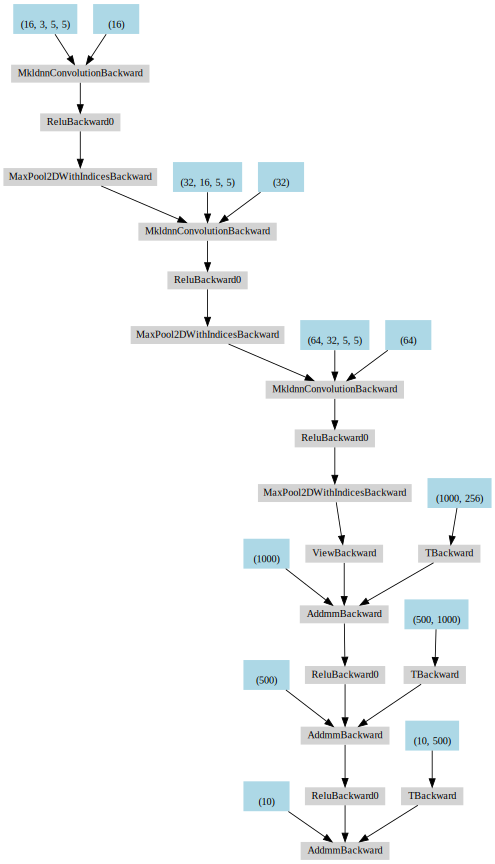

In [48]:
from graphviz import Digraph

for inputs, targets in trainloader:
  break
y = net(inputs)
g = make_dot(y)
g

**Step 5: Plot validation loss and accuracy against training ones** 
- we will notice that models are yet to reach overfitting so increasing the # of epochs can result more accuracy

                                                    Model 0


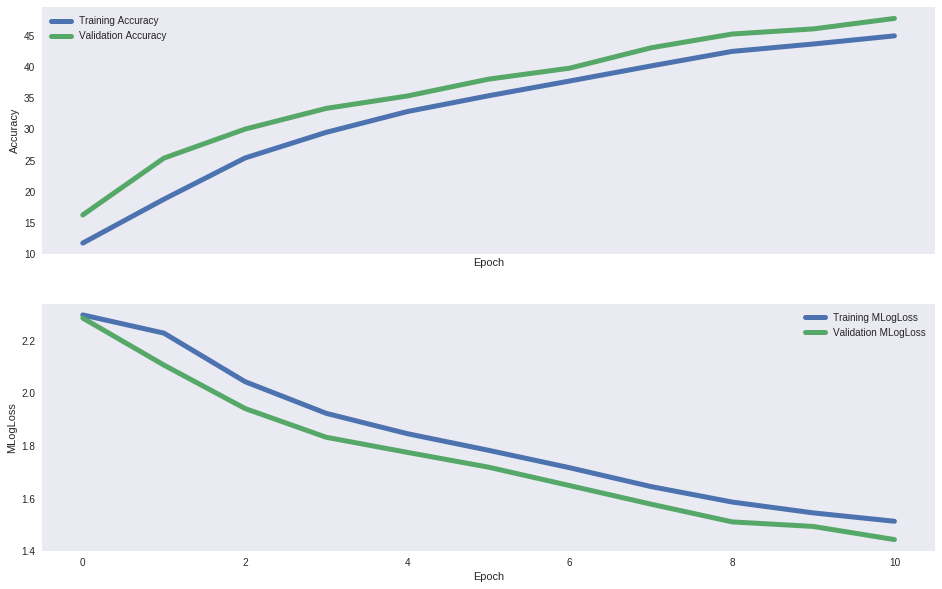

                                                    Model 1


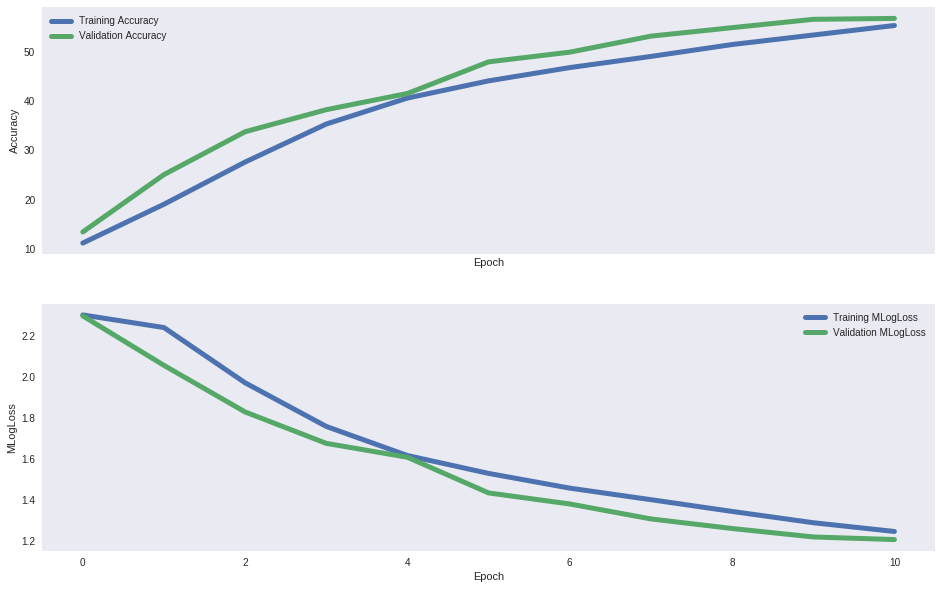

                                                    Model 2


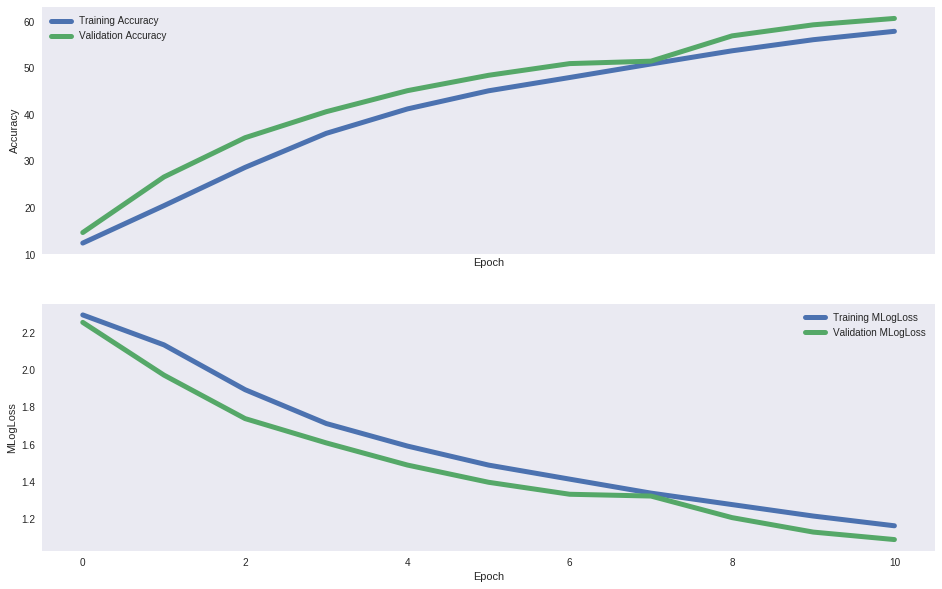

In [54]:
import numpy as np
for i,kernel in enumerate(kernels):
  if len(hist1[i])>1:    
      import matplotlib.pyplot as plt
      plt.rcParams['figure.figsize'] = [16, 10]
      plt.rcParams['font.size'] = 14
      histarr1 = np.array(hist1[i])
      histarr2 = np.array(hist2[i])
      fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
      axs[0].plot(histarr1[:,1], lw=5, label='Training Accuracy')
      axs[0].plot(histarr2[:,1], lw=5, label='Validation Accuracy')
      axs[0].set_ylabel('Accuracy')
      axs[0].set_xlabel('Epoch')
      axs[0].grid()
      axs[0].legend(loc=0)
      axs[1].plot(histarr1[:,0], lw=5, label='Training MLogLoss')
      axs[1].plot(histarr2[:,0], lw=5, label='Validation MLogLoss')
      axs[1].set_ylabel('MLogLoss')
      axs[1].set_xlabel('Epoch')
      axs[1].grid()
      axs[1].legend(loc=0)
      fig.savefig('hist.png', dpi=300)
      print("                                                    Model {}".format(i))
      plt.show();


**Step 6: getting Test accuracies**
    - we will notice that model with filter size = 5 has the best accuracy


In [59]:
for k,kernel in enumerate(kernels):
  print('>>>>>>>>>>>>>>>>>>>>>> Model {} <<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(k))
  model = Cnn(kernel)
  optimizer = optim.SGD(model.parameters(), lr=0.01)
  criterion = nn.CrossEntropyLoss()
  model.load_state_dict(torch.load('model{}.mdl'.format(k)))
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: %d %%' % (
      100 * correct / total))

 # to show the accuracy on each class

  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          c = (predicted == labels).squeeze()
          for i in range(4):
              label = labels[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1


  for i in range(10):
      print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))
  print("")

>>>>>>>>>>>>>>>>>>>>>> Model 0 <<<<<<<<<<<<<<<<<<<<<<<<<<<
Accuracy of the network on the 10000 test images: 46 %
Accuracy of plane : 59 %
Accuracy of   car : 54 %
Accuracy of  bird : 26 %
Accuracy of   cat : 18 %
Accuracy of  deer : 40 %
Accuracy of   dog : 36 %
Accuracy of  frog : 63 %
Accuracy of horse : 43 %
Accuracy of  ship : 52 %
Accuracy of truck : 53 %

>>>>>>>>>>>>>>>>>>>>>> Model 1 <<<<<<<<<<<<<<<<<<<<<<<<<<<
Accuracy of the network on the 10000 test images: 54 %
Accuracy of plane : 45 %
Accuracy of   car : 68 %
Accuracy of  bird : 22 %
Accuracy of   cat : 33 %
Accuracy of  deer : 40 %
Accuracy of   dog : 48 %
Accuracy of  frog : 86 %
Accuracy of horse : 50 %
Accuracy of  ship : 62 %
Accuracy of truck : 68 %

>>>>>>>>>>>>>>>>>>>>>> Model 2 <<<<<<<<<<<<<<<<<<<<<<<<<<<
Accuracy of the network on the 10000 test images: 57 %
Accuracy of plane : 56 %
Accuracy of   car : 64 %
Accuracy of  bird : 34 %
Accuracy of   cat : 34 %
Accuracy of  deer : 46 %
Accuracy of   dog : 52 %
Accura

# Inception V1
## Motivation
    - choosing the right kernel size for the convolution operation becomes tough. A larger kernel is preferred for information that is distributed more globally, and a smaller kernel is preferred for information that is distributed more locally.
    - Very deep networks are prone to overfitting. It also hard to pass gradient updates through the entire network.
    - Naively stacking large convolution operations is computationally expensive.
## Solution
    - We will have filters with multiple sizes operate on the same level, The network essentially would get a bit “wider” rather than “deeper”.
    - 1×1 convolution is used as a dimension reduction module to reduce the computation.

In [0]:
class InceptionV1(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(InceptionV1, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size=1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_3_in, kernel_size=1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_5_in, kernel_size=1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=5, padding=2),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)

# Inception V2
## Motivation
    - Reduce representational bottleneck. The intuition was that, neural networks perform better when convolutions didn’t 
    alter the dimensions of the input drastically, Reducing the dimensions too much may cause loss of information, known as a “representational bottleneck”
    - Using smart factorization methods, convolutions can be made more efficient in terms of computational complexity.
## Solution
    - Factorize 5x5 convolution to two 3x3 convolution operations to improve computational speed. Although this may seem counterintuitive, a 5x5 convolution is 2.78 times more expensive than a 3x3 convolution. So stacking two 3x3 convolutions infact leads to a boost in performance.

In [0]:
class InceptionV2(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(InceptionV2, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size=1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_3_in, kernel_size=1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_5_in, kernel_size=1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
            nn.Conv2d(kernel_5_x, kernel_5_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)

In [0]:
class Cnn_with_inception(nn.Module):
    size = 32
    def __init__(self, kernal,inceptionVersion = "V1"):
        super(Cnn_with_inception, self).__init__()
        self.conv1 = nn.Conv2d(3, 192, kernal, padding=1)
        self.size = (self.size + 3 - kernal) / 2
        self.pool = nn.MaxPool2d(2, 2)
        
        self.a3 = InceptionV1(192,  64,  96, 128, 16, 32, 32)
        if inceptionVersion == "V2":
          print("V2")
          self.a3 = InceptionV2(192,  64,  96, 128, 16, 32, 32)
        
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        
        self.fc1 = nn.Linear(16384, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.a3(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [0]:
# Training
def train(epoch,hist1):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    running_loss = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        running_loss =train_loss
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx % 100 == 99:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch, batch_idx + 1, running_loss/(batch_idx+1)))
            running_loss = 0.0
    hist1.append([train_loss/(batch_idx+1),100.*correct/total])
    print('Training Loss: {:.6f}, Training Accuracy: {:.3f}'.format(train_loss/(batch_idx+1),100.*correct/total))
def test(epoch,hist2,modelNum):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(validationloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    hist2.append([test_loss/(batch_idx+1),100.*correct/total])
    print('Validation Loss: {:.6f}, Validation Accuracy: {:.3f}'.format(test_loss/(batch_idx+1),100.*correct/total))
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt{}.t7'.format(modelNum))
        best_acc = acc


### Training Results
- as expected trainning time was drastically reduced also accuracy become better than before
    - Model 4 (using inception V1 instead of 2 conv2d from above best model)
        - Training Loss: 0.550091, Training Accuracy: 80.500
        - Validation Loss: 0.716014, Validation Accuracy: 75.650
        - Training Time: 419.7023730278015
    - Model 5 (using inception V4)
        - Training Loss: 0.536292, Training Accuracy: 80.993
        - Validation Loss: 0.651241, Validation Accuracy: 77.250
        - 438.30695390701294
- we will notice slightly higher validation accuracy, and change in time

In [120]:
# Model
inceptionVersions = ["V1","V2"]
hist1 = [[],[]]
hist2 = [[],[]]
for i,version in enumerate(inceptionVersions):
  print('==> Building model..')
  net = Cnn_with_inception(5,version)
  net = net.to(device)
  if device == 'cuda':
      net = torch.nn.DataParallel(net)
      cudnn.benchmark = True

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=.001, momentum=0.9)
  start = time.time()
  for epoch in range(10):
    train(epoch,hist1[i])
    test(epoch,hist2[i],i)
  end = time.time()
  print(end - start)
  torch.save(net.state_dict(), 'model{}.mdl'.format(i+3))

==> Building model..

Epoch: 0
[0,   100] loss: 2.162
[0,   200] loss: 1.978
[0,   300] loss: 1.862
[0,   400] loss: 1.780
[0,   500] loss: 1.720
[0,   600] loss: 1.672
[0,   700] loss: 1.632
[0,   800] loss: 1.597
[0,   900] loss: 1.567
[0,  1000] loss: 1.540
Training Loss: 1.539618, Training Accuracy: 43.807
Validation Loss: 1.206507, Validation Accuracy: 56.610

Epoch: 1
[1,   100] loss: 1.224
[1,   200] loss: 1.210
[1,   300] loss: 1.207
[1,   400] loss: 1.192
[1,   500] loss: 1.188
[1,   600] loss: 1.183
[1,   700] loss: 1.173
[1,   800] loss: 1.162
[1,   900] loss: 1.152
[1,  1000] loss: 1.143
Training Loss: 1.143384, Training Accuracy: 58.750
Validation Loss: 1.112093, Validation Accuracy: 61.030

Epoch: 2
[2,   100] loss: 1.037
[2,   200] loss: 1.027
[2,   300] loss: 1.019
[2,   400] loss: 1.013
[2,   500] loss: 1.010
[2,   600] loss: 1.004
[2,   700] loss: 1.002
[2,   800] loss: 0.999
[2,   900] loss: 0.993
[2,  1000] loss: 0.988
Training Loss: 0.988221, Training Accuracy: 64.

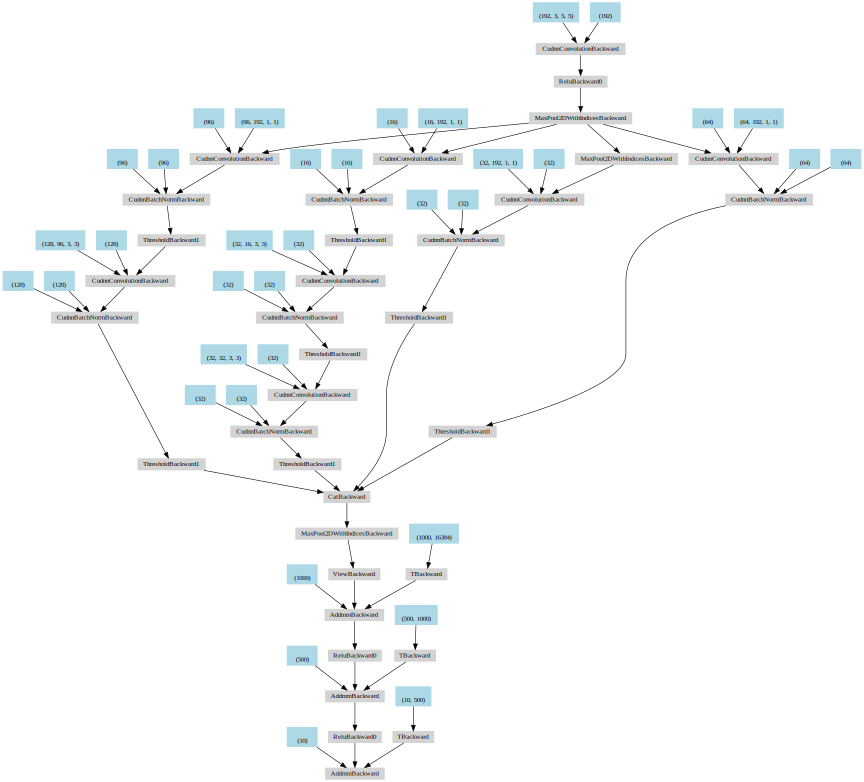

In [122]:
from graphviz import Digraph

for inputs, targets in trainloader:
  break
y = net(inputs.to(device))
g = make_dot(y)
g

                                                    Model 0


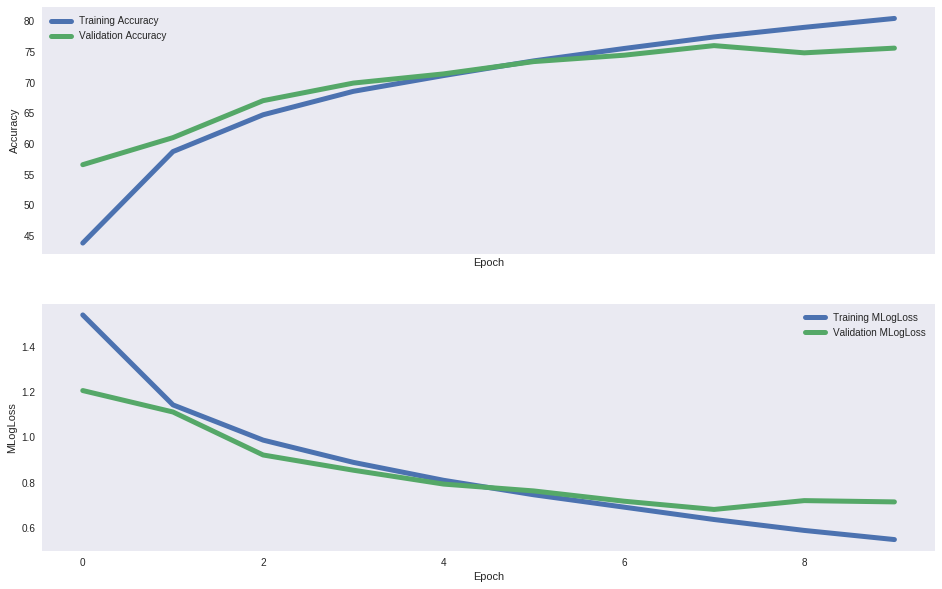

                                                    Model 1


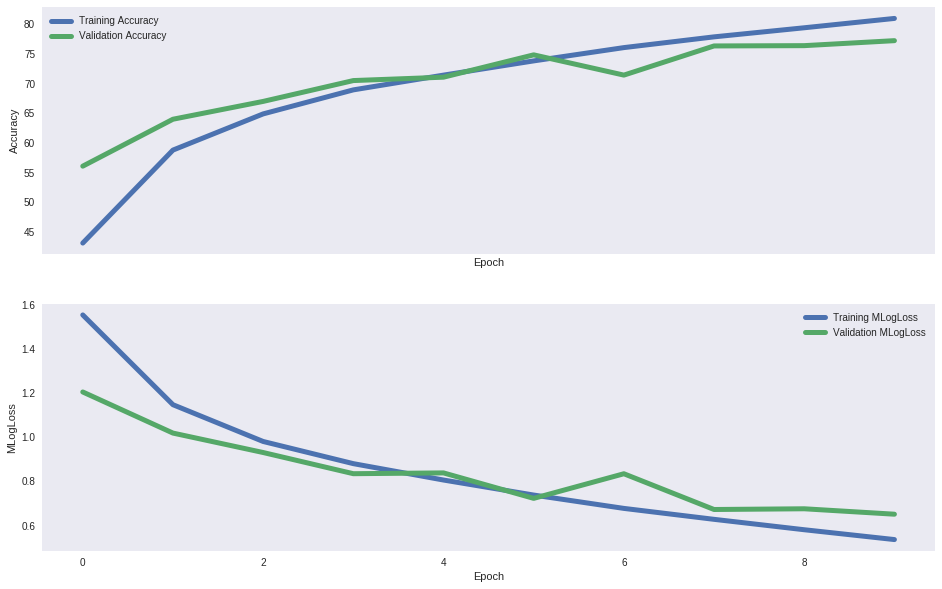

In [123]:
import numpy as np
for i,kernel in enumerate(inceptionVersions):
  if len(hist1[i])>1:    
      import matplotlib.pyplot as plt
      plt.rcParams['figure.figsize'] = [16, 10]
      plt.rcParams['font.size'] = 14
      histarr1 = np.array(hist1[i])
      histarr2 = np.array(hist2[i])
      fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
      axs[0].plot(histarr1[:,1], lw=5, label='Training Accuracy')
      axs[0].plot(histarr2[:,1], lw=5, label='Validation Accuracy')
      axs[0].set_ylabel('Accuracy')
      axs[0].set_xlabel('Epoch')
      axs[0].grid()
      axs[0].legend(loc=0)
      axs[1].plot(histarr1[:,0], lw=5, label='Training MLogLoss')
      axs[1].plot(histarr2[:,0], lw=5, label='Validation MLogLoss')
      axs[1].set_ylabel('MLogLoss')
      axs[1].set_xlabel('Epoch')
      axs[1].grid()
      axs[1].legend(loc=0)
      fig.savefig('hist.png', dpi=300)
      print("                                                    Model {}".format(i))
      plt.show();


### Results on Test Sets
- the accuracy on test set is 73% more than 57 % the previously best model

In [126]:
for k,version in enumerate(inceptionVersions):
  print('>>>>>>>>>>>>>>>>>>>>>> Model {} <<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(k))
  model = Cnn_with_inception(5,version)
  optimizer = optim.SGD(model.parameters(), lr=0.01)
  criterion = nn.CrossEntropyLoss()
  model.load_state_dict(torch.load('model{}.mdl'.format(k+3)))
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: %d %%' % (
      100 * correct / total))

 # to show the accuracy on each class

  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          c = (predicted == labels).squeeze()
          for i in range(4):
              label = labels[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1


  for i in range(10):
      print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))
  print("")

>>>>>>>>>>>>>>>>>>>>>> Model 0 <<<<<<<<<<<<<<<<<<<<<<<<<<<
Accuracy of the network on the 10000 test images: 73 %
Accuracy of plane : 77 %
Accuracy of   car : 78 %
Accuracy of  bird : 61 %
Accuracy of   cat : 49 %
Accuracy of  deer : 77 %
Accuracy of   dog : 65 %
Accuracy of  frog : 87 %
Accuracy of horse : 71 %
Accuracy of  ship : 77 %
Accuracy of truck : 84 %

>>>>>>>>>>>>>>>>>>>>>> Model 1 <<<<<<<<<<<<<<<<<<<<<<<<<<<
Accuracy of the network on the 10000 test images: 73 %
Accuracy of plane : 67 %
Accuracy of   car : 81 %
Accuracy of  bird : 60 %
Accuracy of   cat : 49 %
Accuracy of  deer : 56 %
Accuracy of   dog : 69 %
Accuracy of  frog : 77 %
Accuracy of horse : 76 %
Accuracy of  ship : 88 %
Accuracy of truck : 84 %

